In [2]:
import sys
from numpy import *
import scipy
import pylab
import matplotlib.pyplot as plt # plotting libraries from matlab
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as pl

In [3]:
sys.path.insert(2, '//project/projectdirs/lux/Tools/emcee')
sys.path.insert(2, '//project/projectdirs/lux/Tools/triangle')
import emcee
import triangle

In [4]:
%pylab inline  
#always do this for plotting...  don't ask why
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # set size of figures

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


<h1> Load data and define x and y variable to be fit </h1>

In [5]:
#The means calculated and saved from Run03_Golden_Doke script
data=loadtxt('Run03_Golden_Doke/fits/s2_and_s1_means.txt')  

# The final frozen version backed up on projectdir
#data=loadtxt('/project/projectdirs/lux/data/Run03_Golden_Doke/fits/s2_and_s1_means.txt')  

In [19]:
Energies=[5.2,41.55,163.9,208.3,236.8,409,609,661.6]
#NamesE=["5.3keV","Kr83 42keV","164keV","207keV","237keV","409keV","609keV","662keV"]
NamesE=["x-ray \n 5.3 keV","$\mathrm{^{83m}}$Kr \n 42 keV","$\mathrm{^{131m}}$Xe \n 164 keV",\
        "$\mathrm{^{127}}$Xe \n 208 keV","$\mathrm{^{127}}$Xe, $\mathrm{^{129m}}$Xe \n 236 keV",\
        "$\mathrm{^{127}}$Xe \n 409keV","$\mathrm{^{214}}$Bi \n609 keV","$\mathrm{^{137}}$Cs \n 662 keV"]

mean_s2=data[0]
mean_s2_sig=data[1]
mean_s1=data[2]
mean_s1_sig=data[3]

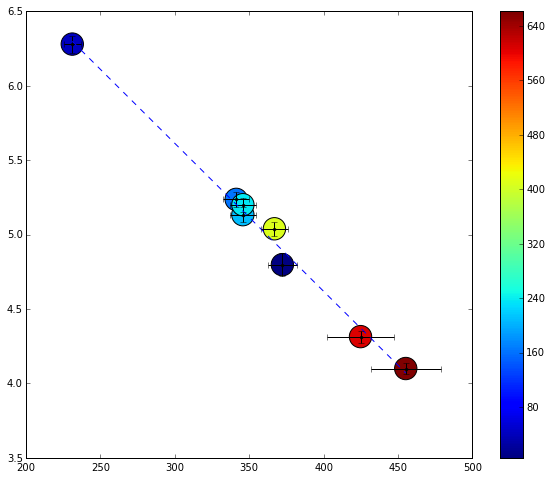

In [7]:
#Define x and y for the Doke plot and start with a linear regression fit.

#Richard's Doke Plot
#Energies=[ 41.5500 , 661.6570,  163.9000 , 236.1000 , 208.3000,  408.7910  ,609.3120]
#x=array([233.2130,  454.9185,  343.3008 , 347.1283 , 344.4983 , 370.3482 , 425.0072])#mean_s2/Energies
#y=array([6.2575 ,   4.1003 ,   5.2166 ,   5.2139  ,   5.1416   , 5.0148 ,   4.2835])#mean_s1/Energies
#yerr=array([0.0477 ,   0.0324   , 0.0406 ,   0.0404  ,  0.0421 ,   0.0385  ,  0.0329])
#xerr=array([11.4112 ,  36.2902 ,  12.1494  , 14.3366 ,  18.7097  , 12.2439  , 24.9826])

#mean_s2[-1]=301159;#
#mean_s1[-1]=2712.52678609;

x=mean_s2/Energies
y=mean_s1/Energies
yerr=sqrt((y*0.009)**2 + (mean_s1_sig/Energies)**2) #y err is mean_s1_sig/Energies + systematic in detector stability for S1 = 0.9%
xerr=sqrt((x*0.025)**2 + (mean_s2_sig/Energies)**2) #x err is mean_s2_sig/Energies + systematic in detector stability for S2 = 2.5%

xerr[-2]=sqrt(xerr[-2]**2 - (x[-2]*0.025)**2 +  (x[-2]*0.053)**2) #add additional uncertainty to Bi S2
xerr[-1]=sqrt(xerr[-1]**2 - (x[-1]*0.025)**2 + (x[-1]*0.052)**2) #add additional uncertainty to Cs S2

#truncate data here if you want, or use all the points
x=x[:]
y=y[:]
yerr=yerr[:]
xerr=xerr[:]
Energies=Energies[:]

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)

# First guess the "true" parameters.
m_guess = slope
b_guess = intercept
#f_true = 0.001

###########Quick scatter plot of the initial fit###########
plt.scatter(x,y,c=Energies[:],s=500)
xx=linspace(min(x),max(x),100);
yy=xx*slope+intercept
plt.plot(xx,yy,'--')
pl.errorbar(x, y, xerr=xerr, yerr=yerr, fmt=".k")
cb=plt.colorbar()


<h1> setup maximum likelyhood estimation </h1>

In [8]:
def lnlike(theta, x, y, xerr, yerr):
    m, b = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + (m*xerr)**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2) )) #- np.log(inv_sigma2) is normalization


#fit around 4 times the mean value of the initial guess... this corresponds to 300% error :) ... plenty
def lnprior(theta, m_guess, b_guess):
    m, b = theta
    if (m_guess-abs(m_guess*3)) < m < (m_guess+abs(m_guess*3)) and (b_guess-abs(b_guess*3)) < b < (b_guess+abs(b_guess*3)):
        return 0.0
    return -np.inf

def lnprob(theta, x, y, xerr, yerr, m_guess, b_guess):
    lp = lnprior(theta, m_guess, b_guess)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, xerr, yerr)

<h1>The Monte Carlo part <br/>
start 2 random walkers each taking 500 steps, 500 times. (one for each variable) </h1>

In [9]:
nll = lambda *args: -lnlike(*args)
result = scipy.optimize.minimize(nll, [m_guess, b_guess], args=(x, y, xerr, yerr))
m_ml, b_ml = result["x"]

ndim, nwalkers = 2, 500
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, xerr, yerr, m_guess, b_guess))
sampler.run_mcmc(pos, 500)

samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

<h3> plot the results of the random walkers. see the values they tendend to move to, given the initial guess </h3>

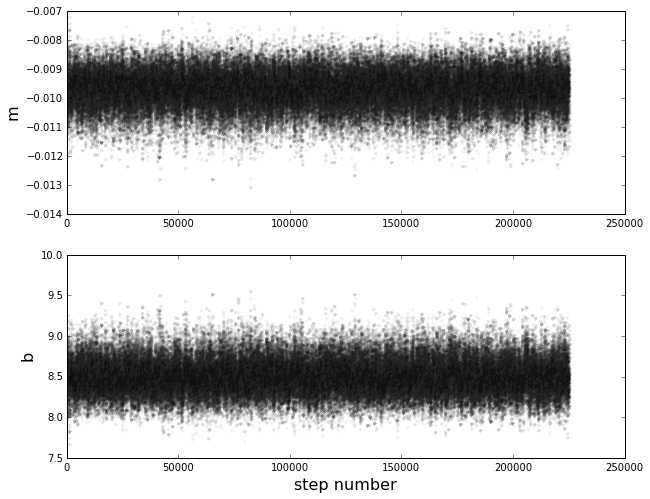

In [10]:
plt.subplot(2, 1, 1)
plt.plot(samples[:,0],'.k',alpha=0.05)
plt.ylabel('m',fontsize=16)

plt.subplot(2, 1, 2)
plt.plot(samples[:,1],'.k',alpha=0.05)
plt.ylabel('b',fontsize=16)
plt.xlabel('step number',fontsize=16)

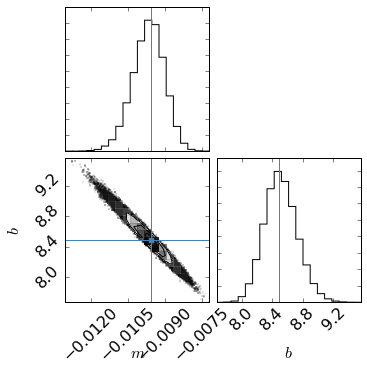

In [11]:
fig = triangle.corner(samples, labels=["$m$", "$b$"],
                      truths=[m_ml, b_ml])
plt.rcParams.update({'font.size': 16})
fig.savefig("Run03_Golden_Doke/triangle.png") # change to your directory

<h1> Now find the 1 sigma bounds of the MCMC, from 16 to 84 percentile <br/> then compare the results </h1>

In [12]:
m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

In [13]:
[m_mcmc, b_mcmc] # these are the results of the MCMC with +/- 1 sigma 

[(-0.009644383257630347, 0.00060399133901506419, 0.00066720189880356551),
 (8.5042976863818911, 0.22219206609953801, 0.20263795061192091)]

In [14]:
g1=array(b_mcmc)/73
g1

array([ 0.11649723,  0.00304373,  0.00277586])

In [15]:
g2=-(array(b_mcmc)/73)/array(m_mcmc)
g2[1]=sqrt((g1[1]/m_mcmc[0])**2 + (m_mcmc[1]*g1[0]/m_mcmc[0]**2)**2)
g2

array([ 12.07928236,   0.81967221,  -4.16045329])

In [16]:
g2/24.66

array([ 0.48983302,  0.03323894, -0.16871262])

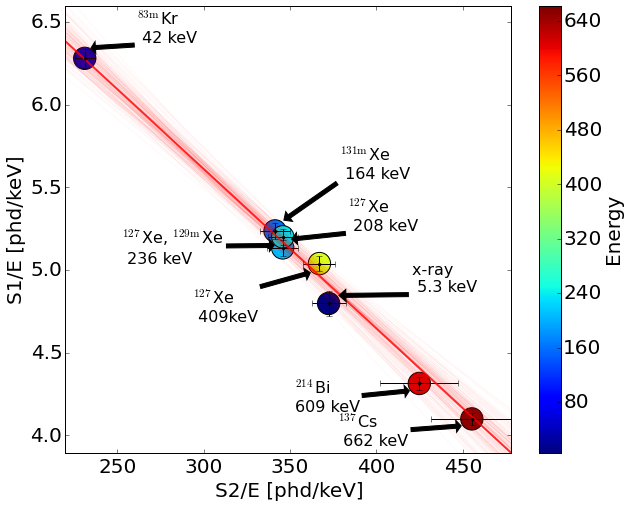

In [20]:
xl = np.array([min(x)*.95, max(x)*1.05])

plt.scatter(x,y,c=Energies[:],s=500)
cb=plt.colorbar()
cb.set_label('Energy')

# Plot with shape Beta Constraint
#for m, b in a:
#    pl.plot(xl, m*xl+b, "-b", alpha=0.1)
#pl.plot(xl, m_beta*xl+b_beta, "-b", lw=4, alpha=0.8) # plot optimal tritium result...

for m, b in samples[np.random.randint(len(samples), size=200)]:
    pl.plot(xl, m*xl+b, color="r", alpha=0.03)

pl.plot(xl, m_mcmc[0]*xl+b_mcmc[0], color="r", lw=2, alpha=0.8)
#pl.plot(xl, m_guess*xl+b_guess, "--b", lw=2, alpha=0.8) # the linear regression fit result.

pl.errorbar(x, y, xerr=xerr, yerr=yerr, fmt=".k")
plt.xlabel('S2/E [phd/keV]')
plt.ylabel('S1/E [phd/keV]')
plt.rcParams.update({'font.size': 20})

plt.xlim([min(x)*.95,max(x)*1.05])
plt.ylim([min(y)*.95,max(y)*1.05])

#add g1 g2 val
#plt.text(1.02*x.max(),1.02*y.max(),'g1={:1.3f} +/- {:1.3f} \n g2={:1.1f} +/- {:1.2f}'.format(g1[0],g1[1],g2[0],g2[1]),
#         horizontalalignment='right', verticalalignment='top', bbox=dict(facecolor='w', alpha=0.9),fontsize=18)
#plt.title('Run03 WS Doke Plot',fontsize=18)

for ii in (0,1):
    ii
    plt.annotate(NamesE[ii], fontsize=16, xy=(x[ii]*1.01,y[ii]*1.01), xytext=(x[ii]*1.13,y[ii]*1.015),
        arrowprops=dict(facecolor='k', shrink=0.05),
        )
for ii in (2,):
    ii
    plt.annotate(NamesE[ii], fontsize=16, xy=(x[ii]*1.01,y[ii]*1.01), xytext=(x[ii]*1.11,y[ii]*1.06),
        arrowprops=dict(facecolor='k', shrink=0.05),
        )
for ii in (3,):
    ii
    plt.annotate(NamesE[ii], fontsize=16, xy=(x[ii]*1.01,y[ii]*1.01), xytext=(x[ii]*1.11,y[ii]*1.02),
        arrowprops=dict(facecolor='k', shrink=0.05),
        )
for ii in (4,):
    ii
    plt.annotate(NamesE[ii], fontsize=16, xy=(x[ii]*.99,y[ii]*.99), xytext=(x[ii]*.73,y[ii]*.97),
        arrowprops=dict(facecolor='k', shrink=0.05),
        )
for ii in (5,):
    ii
    plt.annotate(NamesE[ii], fontsize=16, xy=(x[ii]*.99,y[ii]*.99), xytext=(x[ii]*.80,y[ii]*.93),
        arrowprops=dict(facecolor='k', shrink=0.05),
        )
for ii in (6,7):
    ii
    plt.annotate(NamesE[ii], fontsize=16, xy=(x[ii]*0.99,y[ii]*0.99), xytext=(x[ii]*.83,y[ii]*.96),
        arrowprops=dict(facecolor='k', shrink=0.05),
        )  
#plt.text(300,5.8,'Beta Constraint',color='blue')  
#plt.text(230,5.5,'Doke Constraint',color='red')


#plt.text(300,5.8,'Beta Constraint',color='blue')  
#plt.text(230,5.5,'Doke Constraint',color='red')
#Use latex... doesn't work on Jupyter 
#from matplotlib import rc
#rc('text', usetex=False)

savefig('Run03_Golden_Doke/Doke_Plot_WS.pdf') # change to your directoy
savefig('Run03_Golden_Doke/Doke_Plot_WS.png',dpi=200) # change to your directoy

<h1> Plot with Beta Shape Constraint. First load in data from Tritium beta shape constraint code </h1>

In [17]:
a1=loadtxt('TBetaOpt/NEST_MAX_FLUCS_Sig.txt')
a2=loadtxt('TBetaOpt/NEST_MIN_FLUCS_Sig.txt')
a3=loadtxt('TBetaOpt/TY_MAX_FLUCS_Sig.txt')
a4=loadtxt('TBetaOpt/TY_MIN_FLUCS_Sig.txt')
a5=loadtxt('TBetaOpt/NEST_BOT_FLUCS_Sig.txt')
a6=loadtxt('TBetaOpt/NEST_TOP_FLUCS_Sig.txt')


g1_range=np.arange(0.10,0.1301,0.0002) #scan g1 ... use 0.0002?
g2_range=np.arange(10.0,13.01,0.02) #scan g2

b=concatenate([a1.reshape(151,151,3),a2.reshape(151,151,3),a3.reshape(151,151,3),a4.reshape(151,151,3),
              a5.reshape(151,151,3),a6.reshape(151,151,3)],2)
cut_1sig= b.min(2)<1
xx, yy=meshgrid(g1_range,g2_range)

#the mean g1 and g2 result fromthe beta shape constraint.
b_beta=73*(.115/.9777)
m_beta=-(.115/.9777)/(12.1/.993)

#the array of g1 and g2 results for 1 sigma region from the beta shape constraint.
b_betas=73*(xx/.9777)
m_betas=-(xx/.9777)/(yy/.993)
a=vstack((m_betas[cut_1sig],b_betas[cut_1sig])).T

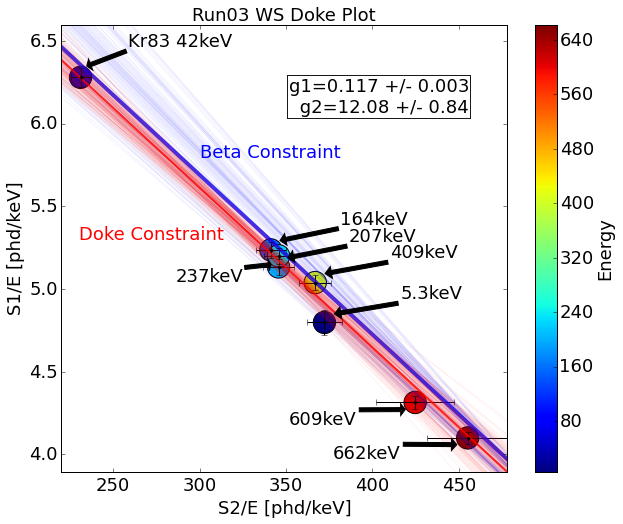

In [89]:
xl = np.array([min(x)*.95, max(x)*1.05])

plt.scatter(x,y,c=Energies[:],s=500)
cb=plt.colorbar()
cb.set_label('Energy')

# Plot with shape Beta Constraint
for m, b in a:
    pl.plot(xl, m*xl+b, "-b", alpha=0.05)
pl.plot(xl, m_beta*xl+b_beta, "-b", lw=4, alpha=0.8) # plot optimal tritium result...

for m, b in samples[np.random.randint(len(samples), size=200)]:
    pl.plot(xl, m*xl+b, color="r", alpha=0.05)

pl.plot(xl, m_mcmc[0]*xl+b_mcmc[0], color="r", lw=2, alpha=0.8)
#pl.plot(xl, m_guess*xl+b_guess, "--b", lw=2, alpha=0.8) # the linear regression fit result.

pl.errorbar(x, y, xerr=xerr, yerr=yerr, fmt=".k")
plt.xlabel('S2/E [phd/keV]')
plt.ylabel('S1/E [phd/keV]')
plt.rcParams.update({'font.size': 18})

plt.xlim([min(x)*.95,max(x)*1.05])
plt.ylim([min(y)*.95,max(y)*1.05])

plt.text(x.max(),y.max(),'g1={:1.3f} +/- {:1.3f} \n g2={:1.2f} +/- {:1.2f}'.format(g1[0],g1[1],g2[0],g2[1]),
         horizontalalignment='right', verticalalignment='top', bbox=dict(facecolor='w', alpha=0.9),fontsize=18)
plt.title('Run03 WS Doke Plot',fontsize=18)

for ii in (0,1,2,3,5):
    ii
    plt.annotate(NamesE[ii], xy=(x[ii]*1.01,y[ii]*1.01), xytext=(x[ii]*1.12,y[ii]*1.03),
        arrowprops=dict(facecolor='k', shrink=0.05),
        )
for ii in (4,6,7):
    ii
    plt.annotate(NamesE[ii], xy=(x[ii]*.99,y[ii]*.99), xytext=(x[ii]*.83,y[ii]*.97),
        arrowprops=dict(facecolor='k', shrink=0.05),
        )  
plt.text(300,5.8,'Beta Constraint',color='blue')  
plt.text(230,5.3,'Doke Constraint',color='red')

savefig('Run03_Golden_Doke/Doke_Plot_WS_and_Beta.pdf') # change to your directoy